<a href="https://colab.research.google.com/github/EmirhanKisa/Machine-Learning/blob/main/Customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# TotalCharges düzeltmesi (Boşlukları sayıya çevir)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

In [ ]:
# (Feature Engineering)
# 1. Tenure Grupları
def tenure_group(t):
    if t <= 12: return 0 # Yeni
    elif t <= 24: return 1 # Orta
    else: return 2 # Sadık
df['TenureGroup'] = df['tenure'].apply(tenure_group)

# 2. Servis Sayısı
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies']
df['ServiceCount'] = (df[services] == 'Yes').sum(axis=1)

# 3. Fiyat Artışı (Gizli Zam)
avg_monthly = df['TotalCharges'] / df['tenure'].replace(0, 1)
df['PriceHike'] = df['MonthlyCharges'] - avg_monthly
df.loc[df['tenure'] == 0, 'PriceHike'] = 0

# 4. Otomatik Ödeme mi?
df['IsAutoPay'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x else 0)

In [ ]:
# LabelEncoder nesnesi
le = LabelEncoder()

# Churn sütununu manuel garantiye alalım (Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Geri kalan tüm sözel (object) sütunları otomatik çevir
for col in df.columns:
    if df[col].dtype == 'object' and col != 'customerID':
        df[col] = le.fit_transform(df[col])

Tüm veriler sayısal formata çevrildi.


In [ ]:
# X ve y'yi belirle
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

# 1. Ayırma (Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Dengeleme (Sadece Train verisi üzerinde!)
train_data = pd.concat([X_train, y_train], axis=1)

# Sınıfları ayır
churn_no = train_data[train_data.Churn == 0]
churn_yes = train_data[train_data.Churn == 1]

# Downsampling (Çoğunluğu azalt)
churn_no_downsampled = resample(churn_no,
                                replace=False,
                                n_samples=len(churn_yes), # Eşitle
                                random_state=42)

# Dengeli seti birleştir
train_balanced = pd.concat([churn_yes, churn_no_downsampled])

# Yeni X_train ve y_train
X_train_bal = train_balanced.drop('Churn', axis=1)
y_train_bal = train_balanced['Churn']

print(f"Orijinal Eğitim Seti: {y_train.value_counts().to_dict()}")
print(f"Dengelenmiş Eğitim Seti: {y_train_bal.value_counts().to_dict()}")

Orijinal Eğitim Seti: {0: 4138, 1: 1496}
Dengelenmiş Eğitim Seti: {1: 1496, 0: 1496}


Model eğitiliyor...

--- MODEL PERFORMANS RAPORU ---
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      1036
           1       0.49      0.86      0.62       373

    accuracy                           0.72      1409
   macro avg       0.71      0.77      0.70      1409
weighted avg       0.81      0.72      0.74      1409

🌟 AUC Skoru: 0.8486


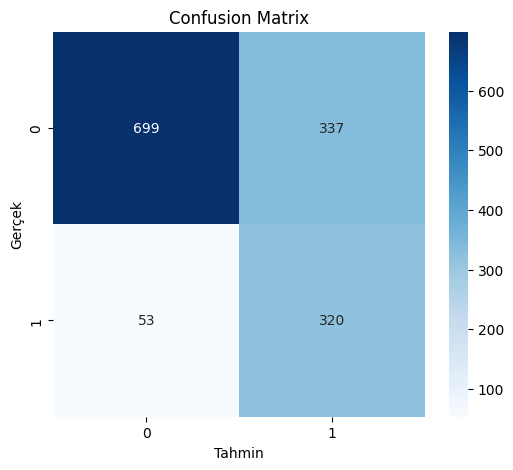

In [ ]:
# Model Kurulumu
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    subsample=1.0,
    random_state=42,
    eval_metric='logloss'
)

# Eğitim
print("Model eğitiliyor...")
xgb_model.fit(X_train_bal, y_train_bal)

# Tahmin
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1] # AUC için olasılıklar

# Raporlama
print("\n--- MODEL PERFORMANS RAPORU ---")
print(classification_report(y_test, y_pred))

# AUC Skoru
auc = roc_auc_score(y_test, y_prob)
print(f"🌟 AUC Skoru: {auc:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

0 : Kalacak müşteriler

1 : Gidecek müşteriler

Amacımız gidicek olan müşterileri yakalamak ve bunu yaparken minimum maliyet ile bunu uygulamak.

Metriklere baktığımızda ise 1 satırındaki recall metriği %86 yani model gidicek olan kişiyi tespit edebiliyor. Ama buna karşılık precision değeri %49 bu ise modelin yanlış alarmı boşu boşuna indirim kupon dağıttığımız anlamına gelir.

# Yorumum
**Modelin iyi yönü :** Gidecek olan müşterileri %86 oranında yakalıyor. Gözünden pek bir şey kaçmıyor. Rastgele tahmin yapmıyor, gerçekten kimin gidip kimin kalacağını %85 ihtimalle ayırt edebiliyor.


**Modelin kötü yönü :** Biraz fazla panik. Şüphelendiği herkese "Gidecek" diyor. Bu yüzden "Gidecek" dediklerinin yarısı aslında kalıyor.

<Figure size 1000x600 with 0 Axes>

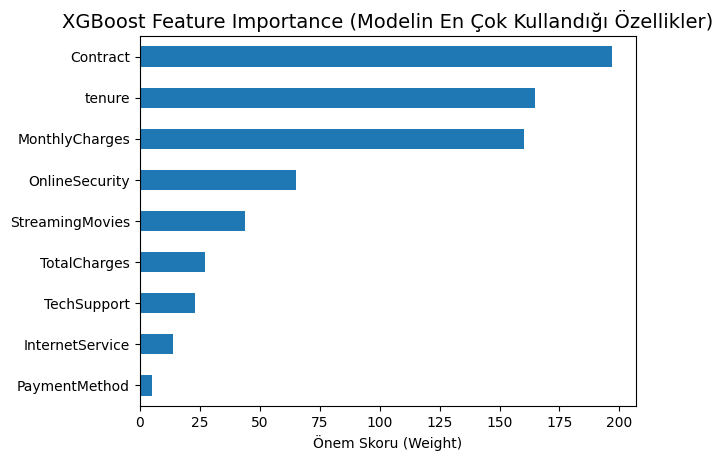

In [ ]:
# --- A. FEATURE IMPORTANCE (Model Hangi Özelliğe Bakıyor?) ---
# XGBoost'un kendi önem derecelerini alalım
feature_important = xgb_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

plt.figure(figsize=(10, 6))
# En önemli 15 özelliği çizdirelim
feature_importance_df.tail(15).plot(kind='barh', color='#1f77b4', legend=False)
plt.title('XGBoost Feature Importance (Modelin En Çok Kullandığı Özellikler)', fontsize=14)
plt.xlabel('Önem Skoru (Weight)')
plt.show()


# FEATURE IMPORTANCE Nedir ?
Yüksek Skor: Model bu özelliğe çok sık bakıyor, kararlarını verirken sürekli bu veriyi kontrol ediyor.

Düşük Skor: Model bu özelliği daha az kullanıyor (ama bu, özelliğin tamamen etkisiz olduğu anlamına gelmez, sadece daha az "sık" soruluyor).

**Contract (Sözleşme)** : (Month-to-month)'ta müşteriler her an gidebilir. Şirket stratejisi, müşterileri uzun vadeli sözleşmelere ikna etmeye odaklanmalıdır.

**Tenure (Abonelik Süresi)** : Müşteri ne kadar uzun kalırsa o kadar iyi.

**MonthlyCharges (Aylık Ücret)** : Yüksek fatura ödeyenler, daha iyi bir teklif bulduklarında gitmeye daha meyilli olabilirler. Fiyat hassasiyeti yüksek.

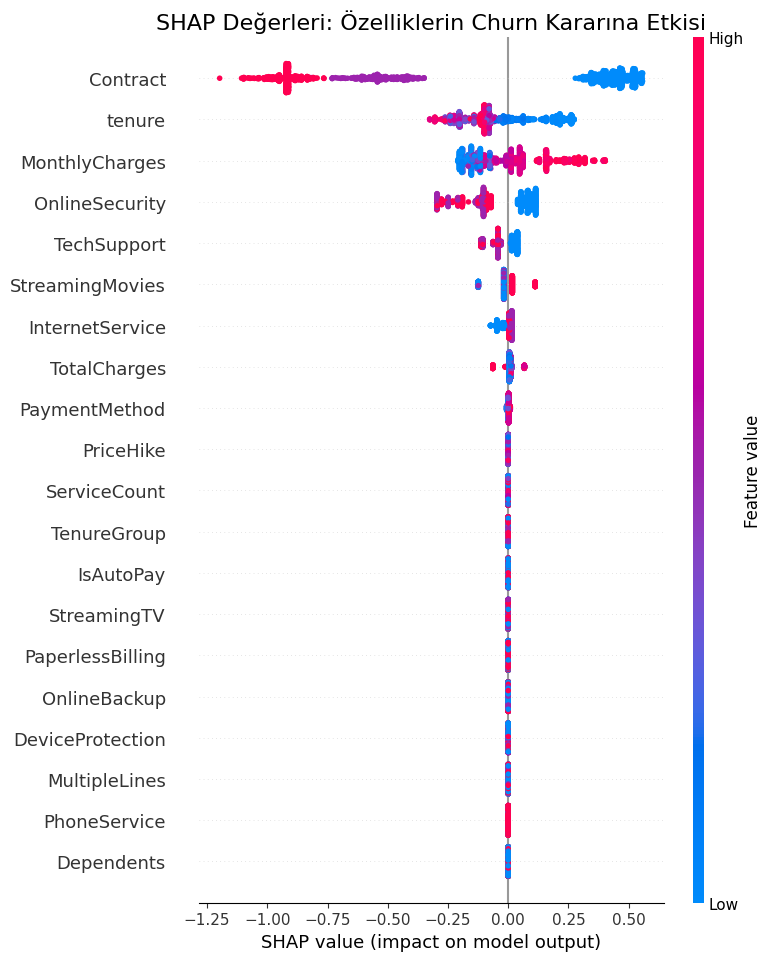

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

# 3. SHAP Değerlerini Hesapla (Test seti üzerinden)
shap_values = explainer.shap_values(X_test)

# 4. ÖZET GRAFİK (Summary Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Değerleri: Özelliklerin Churn Kararına Etkisi", fontsize=16)
plt.show()

# Yorumum

Mavi noktalar = düşük değer / Küçük sayı

Pembe noktalar = yüksek değer / Büyük sayı

Pozitif taraf (sağ taraf) → churn ihtimalini artıran etki

Negatif taraf (sol taraf) → churn ihtimalini azaltan etki



# Contract

En baskın değişken.
Kısa süreli / month-to-month sözleşme (yüksek risk) genelde pembe olup pozitif tarafta → churn ihtimalini yükseltiyor.
Uzun kontratlı müşteriler (düşük risk) mavi olup negatif tarafta → churn ihtimalini düşürüyor.


# Tenure

Tenure düşükse (kısa süredir müşteri, pembe) → churn artıyor.
Tenure yüksekse (uzun süredir müşteri, mavi) → churn düşüyor.
Bu işletme açısından kritik: yeni müşteriler daha kırılgan.

# MonthlyCharges

Aylık ücret yüksek (pembe) → churn pozitif yöne itiliyor.
Yüksek fatura = memnuniyetsiz çıkış riskinin arttığını gösterir.

# OnlineSecurity / TechSupport

Bu servisler yoksa (yüksek risk, pembe) → churn pozitif yöne kayıyor.
Var olanlar (mavi) churn’ü düşürüyor.
İşlevsel anlamı: koruyucu hizmet alan müşteriler daha bağlı.

# Şu ana kadarki bildiklerimiz

*   Modelimiz gidicek olan müşterileri gidicek diye doğru tespit ediyor. Ama bunun yanında gitmiyicek olan müşterileri gidicek diyor.
*   En önemli bağımsız değişkenimiz Contract, Tenure, MonthlyCharges , OnlineSecurity. Yani şirket stratejilerini bunlara bağlı kurmalıyız.
*   Müşteriler ne kadar uzun kalırsa gitmeme ihtimali o kadar uzun.
*   Yüksek para aldığımız kişilerin gitmesi daha olası.
*   Koruyucu hizmet alan müşteriler daha bağlı.

# Yapabiliceğimiz şeyler

*   Herkese büyük inidirm dağıtmamalıyız. Bunun yerine ucuz şekillerde tutundurma sağlamalıyız. (Arama veya mail gibi) ama modeldeki en riskliler kişilerine indirim sunulabilinir.
*   İlk gelen kişilere uzun vadeli düşünerek teklif vermeliyiz. Ve ilk müşterilerimizi ilk ay memnuniyet araması gibi şeyler yapılanabilinir.
*   Müşteri çekmek ve tutundurmak için giriş fiyatı ucuz tuttuk ilerideki müşterileri kaybetmemek adına zam oranını biraz daha azaltarak müşteri tutundurmuş halimiz zam yapmış halimize göre daha karlı olabilir.
*   Koruyucu hizmeti daha cazip hale getirmeliyiz.










